In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import regex as re
from nltk.tokenize import word_tokenize
!pip install gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.multioutput import MultiOutputClassifier
nltk.download('stopwords')  # Download stopwords list if not already present
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming 'corpus' is a list of lists, where each inner list contains words from a document
stop_words = set(stopwords.words('english'))  # Create a set for efficient lookup

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Word Embeddings with Twitter Data**

In [4]:
df = pd.read_csv("twitter_training.csv")
df['Positive'].value_counts() #Here we can see the different outputs

#Create new column with appropriate name
df['Sentiment'] = df['Positive']
df = df.drop(['Positive', '2401', 'Borderlands'], axis=1)

In [5]:
df.tail(10)

,"im getting on borderlands and i will murder you all ,",Sentiment
74671,Let no elite go unnoticed... NVIDIA Highlights...,Positive
74672,Let no elim go unnoticed.... NVIDIA Highlights...,Positive
74673,Let a no information elim that go unnoticed......,Positive
74674,<unk> my elim be no.... NVIDIA Highlights Pict...,Positive
74675,Just realized the windows partition of my Mac ...,Positive
74676,Just realized that the Windows partition of my...,Positive
74677,Just realized that my Mac window partition is ...,Positive
74678,Just realized the windows partition of my Mac ...,Positive
74679,Just realized between the windows partition of...,Positive
74680,Just like the windows partition of my Mac is l...,Positive


In [6]:
df = df.rename(columns={"im getting on borderlands and i will murder you all ,":"Content"})

# **Put words in Reviews into Tokens**

In [7]:
df['Content'] = df['Content'].astype(str)
df['Content'] = df['Content'].apply(word_tokenize)

# **Run Word2Vec Model on Data to place into Vectors**

In [8]:
model = Word2Vec(df['Content'], window=5, vector_size=100, sg=1)

# **Show each words 100 dimension Vector Space**

In [9]:
vectors = [model.wv[token] for row in df['Content'] for token in row if token in model.wv]

#model.wv[token] = any word and its vector space

In [10]:
vectors

[array([ 0.71998686,  0.07849772, -0.2562308 , -0.13684925,  0.3851644 ,
        -0.3955073 ,  0.32243967,  0.33378786, -0.58607125,  0.40399176,
        -0.18817082, -0.035453  ,  0.17657475, -0.15624745,  0.1662897 ,
         0.28292495,  0.19102387, -0.08354761,  0.32723293, -0.17922342,
        -0.18026733, -0.05338549, -0.3874659 , -0.4095082 , -0.11249068,
        -0.0998413 ,  0.1588701 ,  0.2744365 , -0.22936922,  0.12554237,
         0.00748404, -0.33353433, -0.02284364, -0.01299498, -0.4138885 ,
         0.55815643,  0.03094111, -0.0851111 ,  0.0621409 , -0.16145872,
        -0.6632485 ,  0.1960581 ,  0.5150364 ,  0.20498382,  0.6480302 ,
         0.11074199, -0.2980008 ,  0.14810726, -0.05683681,  0.15842953,
        -0.4551633 , -0.02870253, -0.56934315, -0.1208276 ,  0.21371867,
         0.08432683, -0.08476653, -0.37466216, -0.13762358, -0.24655585,
         0.29773772, -0.20884876,  0.30848524,  0.3099459 , -0.01115215,
         0.26748115,  0.22414377,  0.19012162, -0.0

# **Calculate Average Vector Position across all Words in Review**

In [11]:
# Calculate average vector for each review
document_vectors = []
for row in df['Content']:
    row_vectors = [model.wv[token] for token in row if token in model.wv]
    if row_vectors:
        document_vectors.append(np.mean(row_vectors, axis=0))
    else:
        document_vectors.append(np.zeros(model.vector_size))  # Handle cases with no valid tokens

df['Vectors'] = document_vectors

In [12]:
df['Vectors']

0        [0.2896327, 0.059369504, 0.21127343, -0.026249...
1        [0.35828188, -0.05965495, 0.21388482, 0.010713...
2        [0.27201822, -0.054278556, 0.21883115, -0.0071...
3        [0.30215147, -0.10394319, 0.26070714, -0.07948...
4        [0.29104167, -0.18231615, 0.21561235, 0.082026...
                               ...                        
74676    [0.30746105, 0.056118295, 0.23010021, 0.000734...
74677    [0.35313666, 0.04935527, 0.20011781, -0.005804...
74678    [0.32510915, 0.011431587, 0.20234428, 0.027170...
74679    [0.30281124, -0.020729225, 0.2263119, 0.028482...
74680    [0.29461023, -0.002960155, 0.20590223, 0.03142...
Name: Vectors, Length: 74681, dtype: object

In [13]:
df['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

# **One-Hot Encoder**

In [14]:
### USE ONE HOT ENCODER ###

encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df[['Sentiment']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
X = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Sentiment']))
y = df['Vectors']
X

,Sentiment_Irrelevant,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
74676,0.0,0.0,0.0,1.0
74677,0.0,0.0,0.0,1.0
74678,0.0,0.0,0.0,1.0
74679,0.0,0.0,0.0,1.0


# **Split Data into Train and Test**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

# **Run ML model**

In [17]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

# Assuming y_train contains arrays and you want to extract the first element of each array
y_train_updated = np.array([arr[0] for arr in y_train])
y_train_updated = np.array([1 if arr[0] > 0.5 else 0 for arr in y_train])
clf.fit(X_train, y_train_updated)
clf.predict(X_test)

# Convert y_test to a NumPy array with binary labels (adjust threshold as needed)
y_test_updated = np.array([1 if arr[0] > 0.5 else 0 for arr in y_test])
clf.score(X_test, y_test_updated)

0.9903146619058246

# **Dimensionality Reduction using PCA**

In [18]:
### Dimensionality Reduction for plotting ###

vector_data = np.vstack(df['Vectors'].to_numpy())

pca = PCA(n_components = 3)

threedvec = pca.fit_transform(vector_data)

In [19]:
# Create new columns in your DataFrame for each of the 4 components
df['threedvec_1'] = threedvec[:, 0]
df['threedvec_2'] = threedvec[:, 1]
df['threedvec_3'] = threedvec[:, 2]

# **Plot showing Vector position of Review**

<ipython-input-24-fe14d619e806>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c=df['Sentiment'].cat.codes, cmap=plt.cm.get_cmap('tab10', len(df['Sentiment'].cat.categories)))


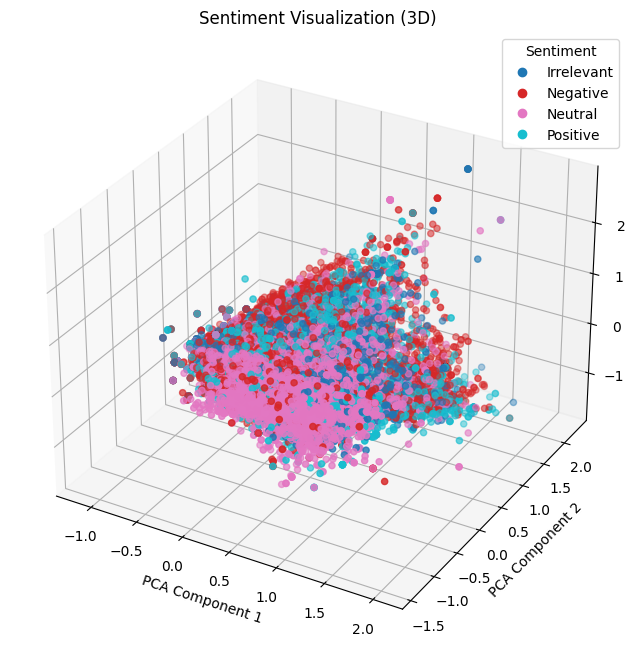

In [24]:
# Convert 'Sentiment' to categorical
df['Sentiment'] = df['Sentiment'].astype('category')


fig = plt.figure(figsize=(10, 8))  # Adjust figure size as needed
ax = fig.add_subplot(111, projection='3d')

# Define a color palette for the sentiment categories
palette = sns.color_palette("tab10", len(df['Sentiment'].cat.categories))

# Create the 3D scatter plot with color based on 'Sentiment'
scatter = ax.scatter(df['threedvec_1'], df['threedvec_2'], df['threedvec_3'],
                     c=df['Sentiment'].cat.codes, cmap=plt.cm.get_cmap('tab10', len(df['Sentiment'].cat.categories)))

# Set labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Sentiment Visualization (3D)')

# Add a legend (optional)
handles, labels = scatter.legend_elements()
legend = ax.legend(handles, df['Sentiment'].cat.categories, loc="upper right", title="Sentiment")

plt.show()